In [1]:
import numpy as np
import random
import time
import signal
from IPython.display import clear_output, display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Variable
import torchvision.transforms as T

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import dataset

## Load data

In [6]:
dataset.download()

file 'train-images-idx3-ubyte.gz' already exists
file 'train-labels-idx1-ubyte.gz' already exists
file 't10k-images-idx3-ubyte.gz' already exists
file 't10k-labels-idx1-ubyte.gz' already exists
done!


In [8]:
print("reading train set ...")
imgsize, train_labels, train_images = dataset.read_train()

print("reading test set ...")
_imgsize, test_labels, test_images = dataset.read_test()

assert(imgsize == _imgsize)
print("done!")

reading train set ...
reading test set ...
done!


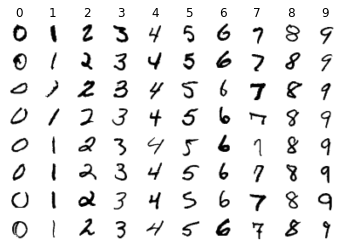

In [9]:
rows = 8
for digit in range(10):
    idxs = np.flatnonzero(np.equal(test_labels, digit))
    idxs = np.random.choice(idxs, rows, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(rows, 10, 10*i + digit + 1)
        plt.imshow(255.0*(1.0 - test_images[idx][0]))
        plt.axis('off')
        if i == 0:
            plt.title(digit)

## Functions and classes

In [10]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [44]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [96]:
class ConvNet(nn.Module):
    def __init__(self, conv, fc, ksize=3, dropout=None):
        super().__init__()
        
        self.kernel_size = ksize
        pad = (ksize - 1)//2;
        
        levels = []
        for level in conv:
            layers = []
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    #nn.BatchNorm2d(conv_out),
                    nn.ReLU(),
                ])
                if dropout is not None:
                    layers.append(nn.Dropout(dropout))
            layers.append(nn.MaxPool2d(2, stride=2))
            levels.append(nn.ModuleList(layers))
        self.conv = nn.ModuleList(levels)
        
        layers = [Flatten()]
        for fc_in, fc_out in zip(fc[:-1], fc[1:]):
            layers.extend([
                nn.Linear(fc_in, fc_out),
                #nn.BatchNorm1d(fc_out),
                nn.ReLU(),
            ])
            if dropout is not None:
                layers.append(nn.Dropout(dropout))
        layers.pop()
        self.fc = nn.ModuleList(layers)
    
    def forward(self, x):
        for d in self.conv:
            for l in d:
                #print(x.shape)
                x = l(x)
            
        for l in self.fc:
            #print(x.shape)
            x = l(x)

        return x

In [13]:
class History:
    def __init__(self):
        self.t = []
        self.acc = []
        self.loss = []
        
    def append(self, t, acc, loss):
        self.t.append(t)
        self.acc.append(acc)
        self.loss.append(loss)

In [14]:
def plot(train, test):
    plt.subplot(2, 1, 1)
    plt.plot(train.t, train.loss, label="Train loss: %.4f" % train.loss[-1])
    plt.plot(test.t, test.loss, label="Test loss: %.4f" % test.loss[-1])
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(train.t, train.acc, label="Train accuracy: %.2f%%" % (100.0*train.acc[-1]))
    plt.plot(test.t, test.acc, label="Test accuracy: %.2f%%" % (100.0*test.acc[-1]))
    plt.title("Accuracy")
    plt.legend()
    
    plt.show()

In [15]:
def shuffle_sync(seqs):
    perm = np.random.permutation(seqs[0].shape[0])
    return [s[perm] for s in seqs]

In [64]:
def step(model, optim, loss_fn, images, labels, train=True):
    if train:
        model.train()
    else:
        model.eval()
    
    images_var = Variable(Tensor(images).cuda())
    labels_var = Variable(Tensor(labels).cuda().long())
    
    if train:
        optim.zero_grad()

    pred_labels_var = model(images_var)
    loss = loss_fn(pred_labels_var, labels_var)
    
    if train:
        loss.backward()
        optim.step()
    
    pred_labels = np.argmax(pred_labels_var.data.cpu().numpy(), axis=1)
    accuracy = np.mean(np.equal(pred_labels, labels))
    
    return loss.data.item(), accuracy

def train(*args, **kwargs):
    return step(*args, **kwargs, train=True)

def test(*args, **kwargs):
    with torch.no_grad():
        return step(*args, **kwargs, train=False)

## Hyperparameters search process

In [150]:
def probe(epochs, model, bs, lr, reg=0):
    loss_fn = nn.CrossEntropyLoss().cuda()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    
    train_acc = 0.0
    test_acc = 0.0
    for k in range(epochs):
        # train
        acc_list = []
        images, labels = shuffle_sync([train_images, train_labels])
        for i in range((labels.shape[0]-1)//bs + 1):
            y = labels[i:i+bs]
            x = images[i:i+bs]
            _, acc = train(model, opt, loss_fn, x, y)
            acc_list.append(acc)
        train_acc = max(train_acc, np.mean(acc_list))
        
        # test
        _, acc = test(model, opt, loss_fn, test_images, test_labels)
        test_acc = max(test_acc, acc)
        
    return train_acc, test_acc

#### Linear classifier

In [100]:
for lr in [1e-1, 1e-3, 1e-5]:
    acc = probe(
        epochs=4,
        model=ConvNet(
            conv=(),
            fc=(28*28, 10),
        ).cuda(),
        bs=1000,
        lr=lr,
    )
    print("lr: %f, accuracy: { train: %f, test: %f }" % (lr, acc[0], acc[1]))

lr: 0.100000, accuracy: { train: 0.980967, test: 0.884400 }
lr: 0.001000, accuracy: { train: 0.924367, test: 0.884500 }
lr: 0.000010, accuracy: { train: 0.221333, test: 0.251800 }


#### Two fully-connected layers

In [101]:
for lr in [1e-1, 1e-3, 1e-5]:
    acc = probe(
        epochs=4,
        model=ConvNet(
            conv=(),
            fc=(28*28, 100, 10),
        ).cuda(),
        bs=1000,
        lr=lr,
    )
    print("lr: %f, accuracy: { train: %f, test: %f }" % (lr, acc[0], acc[1]))

lr: 0.100000, accuracy: { train: 0.969000, test: 0.886500 }
lr: 0.001000, accuracy: { train: 0.966650, test: 0.906800 }
lr: 0.000010, accuracy: { train: 0.468433, test: 0.522300 }


#### Small convolutional model

In [103]:
for lr in [1e-1, 1e-3, 1e-5]:
    acc = probe(
        epochs=4,
        model=ConvNet(
            conv=(
                (1, 2),
                (2, 4),
            ),
            fc=(7*7*4, 10),
        ).cuda(),
        bs=1000,
        lr=lr,
    )
    print("lr: %f, accuracy: { train: %f, test: %f }" % (lr, acc[0], acc[1]))

lr: 0.100000, accuracy: { train: 0.976467, test: 0.916300 }
lr: 0.001000, accuracy: { train: 0.909617, test: 0.894000 }
lr: 0.000010, accuracy: { train: 0.103750, test: 0.098200 }


#### A little bigger convolutional model

In [107]:
for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    acc = probe(
        epochs=4,
        model=ConvNet(
            conv=(
                (1, 2, 4),
                (4, 8, 16),
            ),
            fc=(7*7*16, 100, 10),
        ).cuda(),
        bs=1000,
        lr=lr,
    )
    print("lr: %f, accuracy: { train: %f, test: %f }" % (lr, acc[0], acc[1]))

lr: 0.100000, accuracy: { train: 0.123333, test: 0.100900 }
lr: 0.010000, accuracy: { train: 0.994033, test: 0.958300 }
lr: 0.001000, accuracy: { train: 0.975667, test: 0.939300 }
lr: 0.000100, accuracy: { train: 0.496933, test: 0.615700 }


#### Using dropout

In [165]:
for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    acc = probe(
        epochs=10,
        model=ConvNet(
            conv=(
                (1, 2, 4),
                (4, 8, 16),
            ),
            fc=(7*7*16, 100, 10),
            dropout=0.1,
        ).cuda(),
        bs=1000,
        lr=lr,
    )
    print("lr: %f, accuracy: { train: %f, test: %f }" % (lr, acc[0], acc[1]))

lr: 0.100000, accuracy: { train: 0.112633, test: 0.098000 }
lr: 0.010000, accuracy: { train: 0.906583, test: 0.880800 }
lr: 0.001000, accuracy: { train: 0.885933, test: 0.874900 }
lr: 0.000100, accuracy: { train: 0.756100, test: 0.803600 }


## Final run

In [206]:
model = ConvNet(
    conv=(
        (1, 2, 4),
        (4, 8, 16),
    ),
    fc=(7*7*16, 100, 10),
    dropout=None,
).cuda()

In [207]:
batch_size = 1000
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

In [208]:
epoch = 0
train_history, test_history = History(), History()

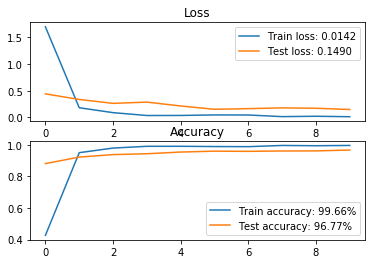

In [209]:
stop_on_signal()
while not signal_done:
    train_loss = 0.0
    train_acc = 0.0
    
    sh_train_images, sh_train_labels = shuffle_sync([train_images, train_labels])
    for i in range((sh_train_labels.shape[0]-1)//batch_size + 1):
        labels = sh_train_labels[i:i+batch_size]
        images = sh_train_images[i:i+batch_size]
        loss, acc = train(model, optimizer, loss_fn, images, labels)
        part = labels.shape[0]/train_labels.shape[0]
        train_loss += loss*part
        train_acc += acc*part
    
    train_history.append(epoch, train_acc, train_loss)

    test_loss, test_acc = test(model, None, loss_fn, test_images, test_labels)
    test_history.append(epoch, test_acc, test_loss)

    clear_output(wait=True)
    plot(train_history, test_history)
    
    epoch += 1